In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from keras.callbacks import ModelCheckpoint

2023-02-28 12:15:59.097404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
A = -0.8
B = 0.16
C = 0.1

dt = 1e-4

# u = [[0]*100 + [.01]*200 + [.02]*200 + [-.01]*200 + [0]*100, [-0.015]*200 + [-.01]*200 + [.01]*200 + [-.01]*200]
u = 1
x = 0

y_arr = []

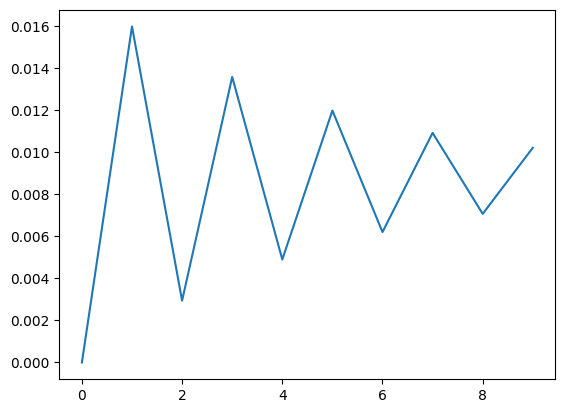

In [3]:
for t in range(10):
    y = C * x

    u = 1 - y

    x = A * x + B * u

    y_arr.append(y)

plt.plot(y_arr)
plt.show()

In [4]:
k_p = 0.12
k_i = 0.06
k_d = 0.007

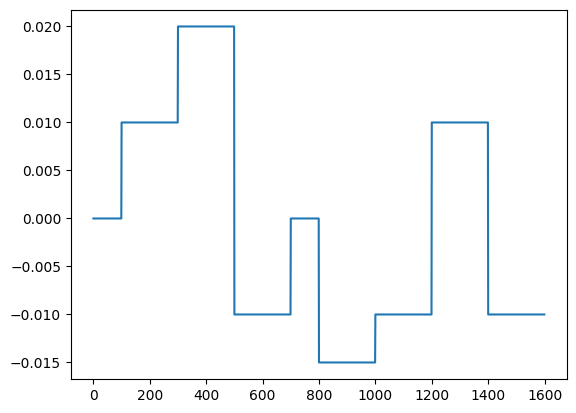

In [5]:
z_ref = [[0]*100 + [.01]*200 + [.02]*200 + [-.01]*200 + [0]*100 + [-0.015]*200 + [-.01]*200 + [.01]*200 + [-.01]*200]
z_ref = np.array(z_ref).reshape(1600,)
plt.plot(z_ref)

In [6]:
e_int = 0
e_past = 0
z_t_arr = []

u = np.zeros((u.shape[0]),)
x = 0

for i in range(z_ref.shape[0]):
    z_t = C * x

    e = z_ref[i] - z_t
    e_diff = e - e_past

    u[i] = e * k_p + e_int * k_i + e_diff * k_d
    x = A * x + B * u[i]

    e_int += e
    e_past = e

    z_t_arr.append(z_t)

z_t_arr = np.array(z_t_arr)
print(z_t_arr.shape)
plt.plot(z_t_arr)
plt.plot(z_ref)
plt.show()

AttributeError: 'float' object has no attribute 'shape'

### Reinforcement Learning

In [2]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [3]:
#Dimension of State Space
num_states = 4
print("Size of State Space ->  {}".format(num_states))
num_actions = 1
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = 0.2
lower_bound = -0.2

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  1
Max Value of Action ->  0.2
Min Value of Action ->  -0.2


In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(256, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh")(out)

    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh")(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
std_dev = 0.001
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.98
# Used to update target networks
tau = 0.01

buffer = Buffer(5000, 32)

2023-02-28 12:16:11.782061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Length between z_t and z_ref
def length_z(z_ref, z_t):
    return abs(z_ref - z_t)

# loss function
def loss(z_ref, z_t):
    return np.power(z_ref - z_t, 2)

# reward function
def GetReward(z_ref, state):
    # loss_value = loss(z_ref, state[1])
    # r = -np.log(loss_value) - np.power(state[0], 2) #* np.exp(loss_value)
    # return r
    r = 0
    length_zt_zref = length_z(z_ref, state[1])
    if length_zt_zref < 0.1: r += 1
    if length_zt_zref < 0.05: r += 10
    if length_zt_zref < 0.01: r += 50
    if length_zt_zref < 0.008: r += 500
    if length_zt_zref < 0.005: r += 1e3

    if length_zt_zref > 0.15: r -= 10
    if length_zt_zref > 0.2: r -= 1e2
    if length_zt_zref > 0.3: r -= 2e2
    if length_zt_zref > 0.4: r -= 5e2

    return r

# generate z_ref command
def z_ref_generate():
    coeff = []
    values = []
    amount = np.random.randint(3, 15)

    for i in range(amount):
        coeff.append(np.random.randint(100,200))
        values.append(np.random.uniform(-0.02,0.02))

    coeff = np.array(coeff)
    values = np.array(values)

    z_ref = []
    for i in range(amount):
        z_ref += [values[i]]*coeff[i]

    return z_ref

# x function
def x_calculate(x, u, A, B):
    return A * x + B * u

# transition function from S state to S' state
def transition(x, u, C, z_ref):
    z_t = C * x
    return (length_z(z_ref, z_t), z_t, z_ref, u)

In [8]:
def policy(state, noise_object):
    # error = loss(target_state, state)
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

Episode * 0 * Avg Reward is ==> -664099.0 z_ref = -7.558054054150478 and z_arr = 676.862782811269


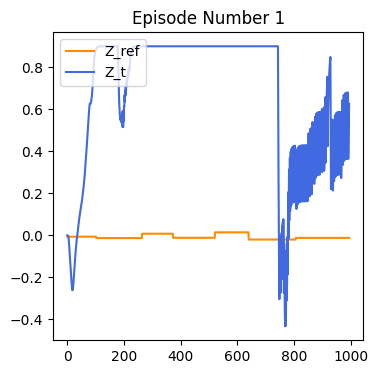

Episode * 1 * Avg Reward is ==> -498274.5 z_ref = -2.4977529188069933 and z_arr = 313.28912711307754
Episode * 2 * Avg Reward is ==> -725843.0 z_ref = 0.7017124862458362 and z_arr = 1294.6448439788026
Episode * 3 * Avg Reward is ==> -777159.5 z_ref = -1.2907486591493404 and z_arr = -1003.0003964664656
Episode * 4 * Avg Reward is ==> -886141.4 z_ref = 3.1413125416528547 and z_arr = 790.4785351206233
Episode * 5 * Avg Reward is ==> -878381.1666666666 z_ref = 14.882338754755706 and z_arr = 921.5530307669671
Episode * 6 * Avg Reward is ==> -975761.0 z_ref = -11.688020139210465 and z_arr = 1368.8544888067229
Episode * 7 * Avg Reward is ==> -1039888.375 z_ref = 2.3112216250332116 and z_arr = 1615.6515061687878
Episode * 8 * Avg Reward is ==> -1077786.2222222222 z_ref = 2.7835845049183194 and z_arr = -1531.6200000000003
Episode * 9 * Avg Reward is ==> -1131035.6 z_ref = -10.268134100209476 and z_arr = -1788.4800000000005
Episode * 10 * Avg Reward is ==> -1209647.1 z_ref = -2.90509285778461 an

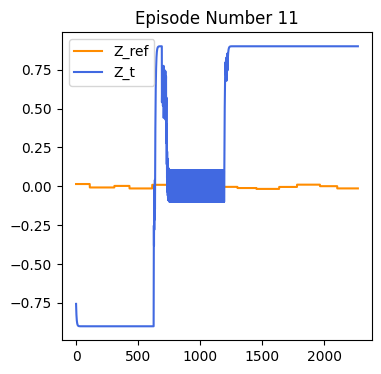

Episode * 11 * Avg Reward is ==> -1316127.1 z_ref = 15.507543673628968 and z_arr = 1551.7800000000002
Episode * 12 * Avg Reward is ==> -1270038.1 z_ref = 4.450936392901479 and z_arr = 799.3800000000003
Episode * 13 * Avg Reward is ==> -1256793.2 z_ref = -6.907653894962541 and z_arr = 886.6800000000003
Episode * 14 * Avg Reward is ==> -1169128.2 z_ref = 3.9413197466554806 and z_arr = -492.1200000000001
Episode * 15 * Avg Reward is ==> -1145191.2 z_ref = -3.5704533723240948 and z_arr = -666.1800000000003
Episode * 16 * Avg Reward is ==> -1101210.2 z_ref = -4.348625759627671 and z_arr = -1243.9800000000005
Episode * 17 * Avg Reward is ==> -1095577.1 z_ref = -1.302664936690698 and z_arr = -1584.1136323584005
Episode * 18 * Avg Reward is ==> -1093155.2 z_ref = 6.67673443226748 and z_arr = 1506.0069058867205
Episode * 19 * Avg Reward is ==> -1040748.2 z_ref = -2.8178052869768075 and z_arr = 1206.1800000000003
Episode * 20 * Avg Reward is ==> -966763.8 z_ref = 4.882286539521468 and z_arr = 78

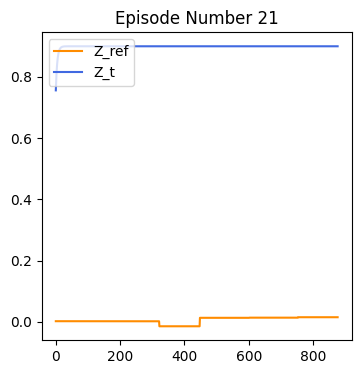

Episode * 21 * Avg Reward is ==> -880363.8 z_ref = 3.200217917837791 and z_arr = 573.4743023206415
Episode * 22 * Avg Reward is ==> -907081.7 z_ref = -1.8596257887373677 and z_arr = 994.2785810903866
Episode * 23 * Avg Reward is ==> -956226.7 z_ref = -1.9036561277509407 and z_arr = 1211.8385400417226
Episode * 24 * Avg Reward is ==> -990092.8 z_ref = 2.7516804568302655 and z_arr = 701.9569025819042
Episode * 25 * Avg Reward is ==> -1021439.8 z_ref = 1.9014289586683093 and z_arr = 758.6051218984041
Episode * 26 * Avg Reward is ==> -1007060.8 z_ref = 2.1253793872608746 and z_arr = 771.0016009018213
Episode * 27 * Avg Reward is ==> -908041.9 z_ref = -1.442257408747094 and z_arr = 330.200658765261
Episode * 28 * Avg Reward is ==> -926653.9 z_ref = 10.958917903061321 and z_arr = 1178.164139436823
Episode * 29 * Avg Reward is ==> -854471.9 z_ref = -0.6151020101263722 and z_arr = 266.4709981838945
Episode * 30 * Avg Reward is ==> -861476.9 z_ref = -6.191569409046437 and z_arr = 567.3630096942

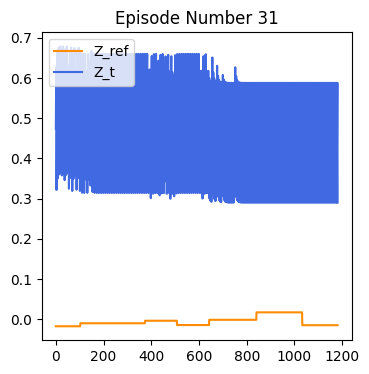

Episode * 31 * Avg Reward is ==> -867480.9 z_ref = 0.8028026690930239 and z_arr = 431.78975609756105
Episode * 32 * Avg Reward is ==> -882675.0 z_ref = 5.094951689921016 and z_arr = 869.485215418267
Episode * 33 * Avg Reward is ==> -827092.0 z_ref = -6.881541754080688 and z_arr = 593.6136374087705
Episode * 34 * Avg Reward is ==> -783098.0 z_ref = 3.940533743905126 and z_arr = 296.60837101093784
Episode * 35 * Avg Reward is ==> -742150.0 z_ref = -2.118243991998858 and z_arr = 419.27016393442636
Episode * 36 * Avg Reward is ==> -667808.0 z_ref = 8.507172326205364 and z_arr = 215.70786885245911
Episode * 37 * Avg Reward is ==> -650162.0 z_ref = -1.1213983394161804 and z_arr = 222.1200000000001
Episode * 38 * Avg Reward is ==> -572291.5 z_ref = 0.5448736726643455 and z_arr = 641.8220465056178
Episode * 39 * Avg Reward is ==> -565850.8 z_ref = 0.49360415249985845 and z_arr = 280.69560420328247
Episode * 40 * Avg Reward is ==> -531100.0 z_ref = -5.780553277400222 and z_arr = 388.41829906019

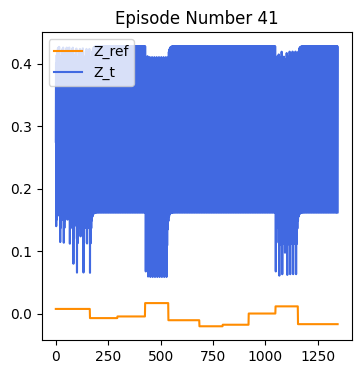

Episode * 41 * Avg Reward is ==> -500558.8 z_ref = 3.6186312637846596 and z_arr = 313.87834806344165
Episode * 42 * Avg Reward is ==> -434166.6 z_ref = -1.056985412270961 and z_arr = 507.9911105322949
Episode * 43 * Avg Reward is ==> -382831.0 z_ref = -1.067194236830747 and z_arr = 284.0005773641085
Episode * 44 * Avg Reward is ==> -371329.7 z_ref = -1.1623049169816557 and z_arr = 341.44423361419376
Episode * 45 * Avg Reward is ==> -342802.0 z_ref = 4.489076728743434 and z_arr = 399.6689030020448
Episode * 46 * Avg Reward is ==> -325995.2 z_ref = -0.6207202711405873 and z_arr = 172.12686859828506
Episode * 47 * Avg Reward is ==> -307105.4 z_ref = -2.4045389093922434 and z_arr = 147.44201808662547
Episode * 48 * Avg Reward is ==> -245152.7 z_ref = -4.461521349353525 and z_arr = 318.06878117300516
Episode * 49 * Avg Reward is ==> -218842.8 z_ref = 3.608812973360961 and z_arr = 89.53782512258303
Episode * 50 * Avg Reward is ==> -181186.0 z_ref = 3.2930495965962554 and z_arr = 268.36386675

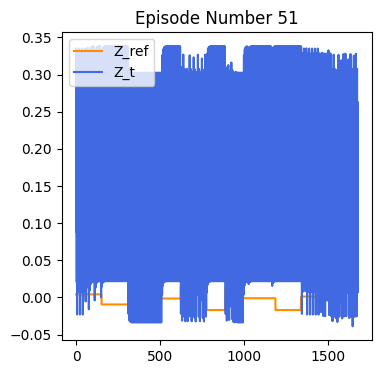

Episode * 51 * Avg Reward is ==> -163067.8 z_ref = -10.772280862481445 and z_arr = 309.24177603819635
Episode * 52 * Avg Reward is ==> -124627.7 z_ref = -9.2787530030338 and z_arr = 238.72239593149328
Episode * 53 * Avg Reward is ==> -217678.0 z_ref = 3.922427921048217 and z_arr = -1276.9184578772015
Episode * 54 * Avg Reward is ==> -284594.3 z_ref = 0.4174567358730559 and z_arr = -997.3800000000003
Episode * 55 * Avg Reward is ==> -398384.9 z_ref = 4.406321421481087 and z_arr = 307.3227141965624
Episode * 56 * Avg Reward is ==> -452963.7 z_ref = 0.23832940235779515 and z_arr = 677.0116039502342
Episode * 57 * Avg Reward is ==> -577546.5 z_ref = 3.8268115394390962 and z_arr = 1468.9800000000005
Episode * 58 * Avg Reward is ==> -650400.7 z_ref = 0.9162040656429875 and z_arr = 969.4800000000004
Episode * 59 * Avg Reward is ==> -694288.3 z_ref = -2.555060846481742 and z_arr = 440.96267472889474
Episode * 60 * Avg Reward is ==> -745677.9 z_ref = -2.666596117400405 and z_arr = 586.475800931

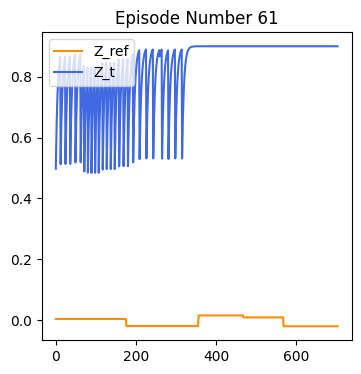

Episode * 61 * Avg Reward is ==> -888017.3 z_ref = -0.26190102415687555 and z_arr = 1480.9075139063784
Episode * 62 * Avg Reward is ==> -979044.6 z_ref = 8.700694346389074 and z_arr = 858.5352028343077
Episode * 63 * Avg Reward is ==> -995727.9 z_ref = -1.5114957368522934 and z_arr = 1067.8482516645167
Episode * 64 * Avg Reward is ==> -955515.9 z_ref = 6.3049222223752714 and z_arr = 391.45408704352207
Episode * 65 * Avg Reward is ==> -895384.0 z_ref = -3.620726702705587 and z_arr = 567.8620724991983
Episode * 66 * Avg Reward is ==> -872049.0 z_ref = 2.878695219598631 and z_arr = 285.92533849654603
Episode * 67 * Avg Reward is ==> -884663.0 z_ref = -9.584054860345098 and z_arr = 1070.3082064073851
Episode * 68 * Avg Reward is ==> -867609.0 z_ref = -3.5637367361638117 and z_arr = 516.6561135205282
Episode * 69 * Avg Reward is ==> -930768.0 z_ref = 0.07346432193402652 and z_arr = 812.0085301490947
Episode * 70 * Avg Reward is ==> -959354.0 z_ref = -1.9841265581233287 and z_arr = 689.71878

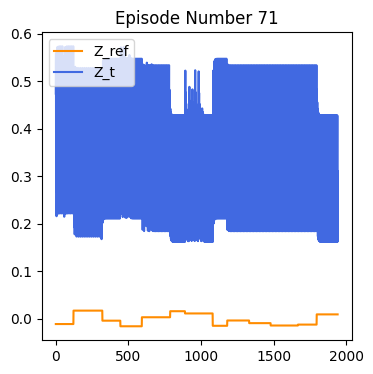

Episode * 71 * Avg Reward is ==> -835348.0 z_ref = 4.667079155088311 and z_arr = 251.60115267433872
Episode * 72 * Avg Reward is ==> -782922.0 z_ref = -2.107943654973685 and z_arr = 397.08000000000015
Episode * 73 * Avg Reward is ==> -709220.9 z_ref = -0.15222390441020028 and z_arr = 478.92983606557397
Episode * 74 * Avg Reward is ==> -697269.2 z_ref = 4.670706676603498 and z_arr = 372.4162447292457
Episode * 75 * Avg Reward is ==> -659242.9 z_ref = 8.36025633002642 and z_arr = 459.8794465877873
Episode * 76 * Avg Reward is ==> -638432.4 z_ref = 3.984296032130694 and z_arr = 214.11556898906653
Episode * 77 * Avg Reward is ==> -510193.3 z_ref = 0.4471795186924745 and z_arr = 278.75523932308965
Episode * 78 * Avg Reward is ==> -458458.2 z_ref = -11.504651058528536 and z_arr = 268.4040017682559
Episode * 79 * Avg Reward is ==> -373004.1 z_ref = -7.749353453086026 and z_arr = 398.6675514689258
Episode * 80 * Avg Reward is ==> -294182.2 z_ref = -1.9306956717496848 and z_arr = 174.6294194095

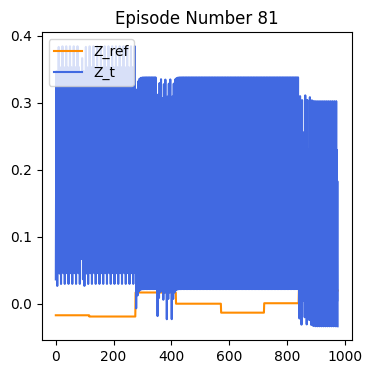

Episode * 81 * Avg Reward is ==> -267996.9 z_ref = 3.337586711665918 and z_arr = 73.15434634995806
Episode * 82 * Avg Reward is ==> -224561.2 z_ref = 4.096382788153552 and z_arr = 160.33626461822308
Episode * 83 * Avg Reward is ==> -171129.3 z_ref = -4.3062926722734645 and z_arr = 90.72907089045313
Episode * 84 * Avg Reward is ==> -142696.7 z_ref = 3.1019921579212983 and z_arr = 292.1688880051047
Episode * 85 * Avg Reward is ==> -252228.7 z_ref = -6.372041252628192 and z_arr = -1631.5184578772019
Episode * 86 * Avg Reward is ==> -401631.1 z_ref = 10.849602570635376 and z_arr = -390.5037674837092
Episode * 87 * Avg Reward is ==> -445814.2 z_ref = 4.865438677523472 and z_arr = 675.1800000000003
Episode * 88 * Avg Reward is ==> -461467.3 z_ref = 1.40798145451589 and z_arr = 379.08000000000015
Episode * 89 * Avg Reward is ==> -569836.4 z_ref = 8.855105664992985 and z_arr = 1484.2800000000004
Episode * 90 * Avg Reward is ==> -702651.2 z_ref = 12.464296047971544 and z_arr = 1385.131405414275

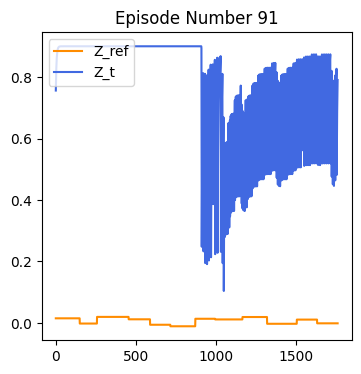

Episode * 91 * Avg Reward is ==> -818255.5 z_ref = 0.8215448109093879 and z_arr = 1109.064142578776
Episode * 92 * Avg Reward is ==> -966605.2 z_ref = 0.1141014016479791 and z_arr = 1298.2414208903806
Episode * 93 * Avg Reward is ==> -1106043.2 z_ref = 3.4895454151157397 and z_arr = 1104.6701781683573
Episode * 94 * Avg Reward is ==> -1182262.5 z_ref = -1.6059971551375005 and z_arr = 648.7880301774046
Episode * 95 * Avg Reward is ==> -1085260.8 z_ref = -1.572944270336021 and z_arr = 380.8161732508331
Episode * 96 * Avg Reward is ==> -970316.9 z_ref = -0.0792694772363689 and z_arr = 380.0364599121708
Episode * 97 * Avg Reward is ==> -1040662.9 z_ref = 4.033519774747962 and z_arr = 930.2244187363043
Episode * 98 * Avg Reward is ==> -1051001.9 z_ref = 2.8193670506487445 and z_arr = 329.18975609756103
Episode * 99 * Avg Reward is ==> -941474.9 z_ref = 1.330959775589439 and z_arr = 181.37024390243906
Episode * 100 * Avg Reward is ==> -886815.0 z_ref = -3.7415241736678153 and z_arr = 643.071

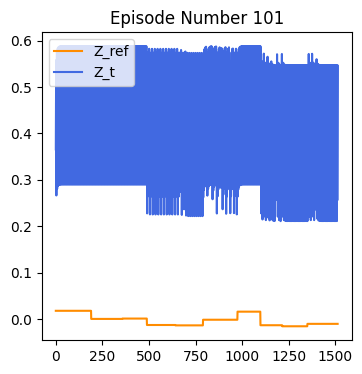

Episode * 101 * Avg Reward is ==> -818049.0 z_ref = 8.174216386129558 and z_arr = 416.12546928333137
Episode * 102 * Avg Reward is ==> -688229.0 z_ref = -4.630456858360835 and z_arr = 185.97725094533743
Episode * 103 * Avg Reward is ==> -593572.0 z_ref = -8.637561699870291 and z_arr = 401.32505657160493
Episode * 104 * Avg Reward is ==> -531572.0 z_ref = -6.9257182850131835 and z_arr = 187.92000319214392
Episode * 105 * Avg Reward is ==> -536902.0 z_ref = -3.529650824327806 and z_arr = 456.7145936541674
Episode * 106 * Avg Reward is ==> -537910.9 z_ref = 4.637418841508973 and z_arr = 443.35770491803294
Episode * 107 * Avg Reward is ==> -480238.9 z_ref = -2.237948647520877 and z_arr = 611.8200000000003
Episode * 108 * Avg Reward is ==> -512168.9 z_ref = 0.7286789136802305 and z_arr = 643.3701639344265
Episode * 109 * Avg Reward is ==> -534916.9 z_ref = -0.2827196290551055 and z_arr = 394.0701639344264
Episode * 110 * Avg Reward is ==> -531062.9 z_ref = 3.229175489180054 and z_arr = 674.

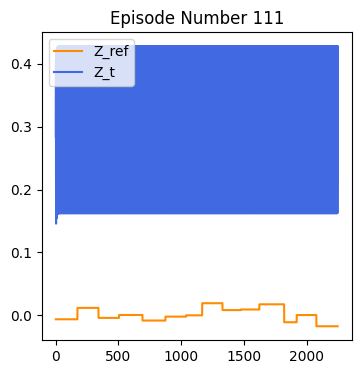

Episode * 111 * Avg Reward is ==> -525984.8 z_ref = 6.579716342050796 and z_arr = 392.22000000000014
Episode * 112 * Avg Reward is ==> -560952.8 z_ref = -4.550893899131399 and z_arr = 478.08000000000015
Episode * 113 * Avg Reward is ==> -562329.8 z_ref = -1.695283327285698 and z_arr = 423.3422950819674
Episode * 114 * Avg Reward is ==> -591177.8 z_ref = -6.3668227388147205 and z_arr = 423.6078688524592
Episode * 115 * Avg Reward is ==> -608213.8 z_ref = 0.46903172226015766 and z_arr = 604.457704918033
Episode * 116 * Avg Reward is ==> -593756.8 z_ref = -0.14022461943528186 and z_arr = 313.92000000000013
Episode * 117 * Avg Reward is ==> -555487.8 z_ref = -8.388357659479361 and z_arr = 281.4078688524591
Episode * 118 * Avg Reward is ==> -493821.7 z_ref = 1.0811778711662088 and z_arr = 119.52000000000005
Episode * 119 * Avg Reward is ==> -514766.7 z_ref = -6.323860900662673 and z_arr = 550.0800000000002
Episode * 120 * Avg Reward is ==> -448411.7 z_ref = 2.9580409812790944 and z_arr = 12

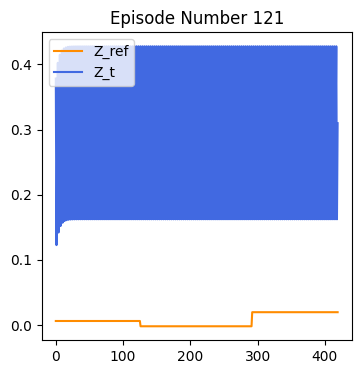

Episode * 121 * Avg Reward is ==> -443054.8 z_ref = -10.973389373068965 and z_arr = 312.48000000000013


KeyboardInterrupt: 

In [9]:
# actor_model.load_weights("../weights/nn_actor.h5")
# critic_model.load_weights("../weights/nn_critic.h5")

# target_actor.load_weights("../weights/nn_target_actor.h5")
# target_critic.load_weights("../weights/nn_target_critic.h5")

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
# Define matrixes
A = 0.8
B = 0.9
C = 1
# Define start value x
x = 0
u = 0


total_episodes = 500
for ep in range(total_episodes):

    z_ref = z_ref_generate()
    z_ref = np.array(z_ref)
    z_arr = []

    x = x_calculate(x, u, A, B)
    z_t = C * x

    prev_state = (length_z(z_ref[0], z_t), z_t, z_ref[0], u)
    episodic_reward = 0

    t = 0
    dt = 1

    for step in range(z_ref.shape[0]):
    # while percent(z_ref[step], state)
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        # prev_state = z_ref[step]

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        # z_ref = tf.expand_dims(tf.convert_to_tensor(), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        x = x_calculate(x, float(action[0]), A, B)
        state = transition(x, float(action[0]), C, z_ref[step])
        # state = float(action[0])
        reward = GetReward(z_ref[step], state)
        z_arr.append(state[1])

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # t += dt

        prev_state = state

    ep_reward_list.append(episodic_reward)
    # Mean of last 10 episodes
    avg_reward = np.mean(ep_reward_list[-10:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward),
        "z_ref = {} and z_arr = {}".format(np.sum(z_ref), np.sum(np.array(z_arr))))
    avg_reward_list.append(avg_reward)

    if ep % 10 == 0:
        fig, ax = plt.subplots(figsize=(4, 4))
        # ax.axis('equal')
        title = "{} {}".format("Episode Number", ep+1)

        ax.plot(z_ref, color = 'darkorange', label = 'Z_ref')
        ax.plot(z_arr, color = 'royalblue', label = 'Z_t')

        ax.legend(loc = 'upper left')
        plt.title(title)
        plt.show()

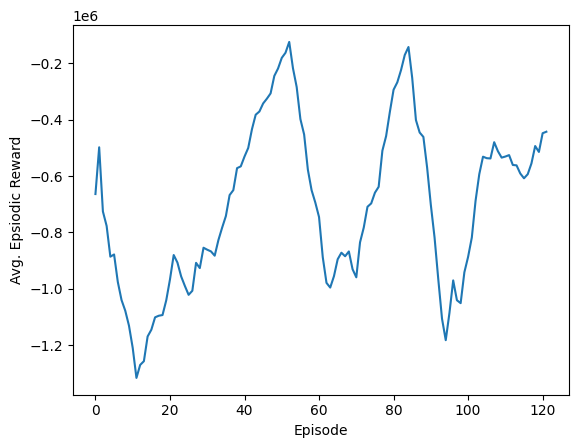

In [10]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [11]:
# Save the weights
actor_model.save_weights("../weights/nn_actor.h5")
critic_model.save_weights("../weights/nn_critic.h5")

target_actor.save_weights("../weights/nn_target_actor.h5")
target_critic.save_weights("../weights/nn_target_critic.h5")

### Supervised Learning